In [1]:
!pip install pandas numpy
import pandas as pd


In [3]:
import numpy as np
import random
import math
import pandas as pd
from copy import deepcopy

class TabuSearchLMDRP:
    def __init__(self, sites, spots, shops, orders, couriers, max_iterations=100, tabu_tenure=10):
        self.sites = sites
        self.spots = spots
        self.shops = shops
        self.orders = orders
        self.couriers = couriers
        self.max_iterations = max_iterations
        self.tabu_tenure = tabu_tenure
        self.tabu_list = []
        self.best_solution = None
        self.best_cost = float('inf')

    def initialize_solution(self):
        """ Generates an initial feasible solution using a greedy approach. """
        solution = {courier: [] for courier in self.couriers}

        for order_id, order in self.orders.iterrows():
            if pd.isna(order['Shop_id']) or pd.isna(order['Spot_id']):
                continue  #skip orders with missing IDs
            assigned_courier = random.choice(self.couriers)
            solution[assigned_courier].append(order_id)

        return solution

    def evaluate_solution(self, solution):
        """ Evaluates the total cost (time, delay, capacity violations). """
        total_time = 0
        penalty = 0

        for courier, deliveries in solution.items():
            if not deliveries:
                continue

            time_spent = 0
            for order_id in deliveries:
                order = self.orders.loc[order_id]
                travel_time = self.calculate_travel_time(order)
                time_spent += travel_time

                if 'Delivery_time' in order and not pd.isna(order['Delivery_time']):
                    try:
                        delivery_time = str(order['Delivery_time']).strip()
                        if time_spent > self.convert_time_to_minutes(delivery_time):
                            penalty += (time_spent - self.convert_time_to_minutes(delivery_time)) * 10#late penalty
                    except:
                        penalty += 100#default penalty for malformed time

            total_time += time_spent

        return total_time + penalty

    def calculate_travel_time(self, order):
        """ Estimates travel time using Haversine formula. """
        EARTH_RADIUS = 6378.137
        velocity = 0.25

        if order['Shop_id'] not in self.shops.index:
            return float('inf')

        shop = self.shops.loc[order['Shop_id']]
        spot = self.spots.loc[order['Spot_id']]

        delta_lng = (spot['Lng'] - shop['Lng']) / 2
        delta_lat = (spot['Lat'] - shop['Lat']) / 2
        angle = math.asin(math.sqrt(
            math.sin(math.pi * delta_lat / 180) ** 2 +
            math.cos(math.pi * shop['Lat'] / 180) * math.cos(math.pi * spot['Lat'] / 180) *
            math.sin(math.pi * delta_lng / 180) ** 2
        ))

        return round(2 * EARTH_RADIUS * angle / velocity)

    def generate_neighbors(self, solution):
        """ Generates neighboring solutions by swapping deliveries. """
        neighbors = []
        for _ in range(5):
            new_solution = deepcopy(solution)
            courier1, courier2 = random.sample(self.couriers, 2)
            if new_solution[courier1] and new_solution[courier2]:
                order1 = random.choice(new_solution[courier1])
                order2 = random.choice(new_solution[courier2])

                new_solution[courier1].remove(order1)
                new_solution[courier2].remove(order2)

                new_solution[courier1].append(order2)
                new_solution[courier2].append(order1)

                neighbors.append(new_solution)
        return neighbors

    def convert_time_to_minutes(self, t: str) -> int:
        """ Converts time in HH:MM format to minutes. """
        try:
            hours, minutes = map(int, t.split(':'))
            return hours * 60 + minutes
        except:
            return 0

    def run(self):
        """ Executes the Tabu Search algorithm. """
        current_solution = self.initialize_solution()
        current_cost = self.evaluate_solution(current_solution)

        self.best_solution = current_solution
        self.best_cost = current_cost

        for iteration in range(self.max_iterations):
            neighbors = self.generate_neighbors(current_solution)
            best_neighbor = None
            best_neighbor_cost = float('inf')

            for neighbor in neighbors:
                if neighbor in self.tabu_list:
                    continue

                cost = self.evaluate_solution(neighbor)
                if cost < best_neighbor_cost:
                    best_neighbor = neighbor
                    best_neighbor_cost = cost

            if best_neighbor is None:
                break

            current_solution = best_neighbor
            current_cost = best_neighbor_cost

            if current_cost < self.best_cost:
                self.best_solution = current_solution
                self.best_cost = current_cost

            self.tabu_list.append(best_neighbor)
            if len(self.tabu_list) > self.tabu_tenure:
                self.tabu_list.pop(0)

            print(f"Iteration {iteration + 1}: Best Cost = {self.best_cost}")

        return self.best_solution, self.best_cost


if __name__ == "__main__":
    sites = pd.read_csv("/content/drive/MyDrive/Dataset/new_1.csv", index_col=0)
    spots = pd.read_csv("/content/drive/MyDrive/Dataset/new_2.csv", index_col=0)
    shops = pd.read_csv("/content/drive/MyDrive/Dataset/new_3.csv", index_col=0)

    orders_ecommerce = pd.read_csv("/content/drive/MyDrive/Dataset/new_4.csv", dtype={"Order_id": str})
    orders_o2o = pd.read_csv("/content/drive/MyDrive/Dataset/new_5.csv", dtype={"Order_id": str})
    orders_ecommerce.set_index("Order_id", inplace=True)
    orders_o2o.set_index("Order_id", inplace=True)
    orders = pd.concat([orders_ecommerce, orders_o2o])
    orders = orders[~orders.index.duplicated(keep="first")]

    couriers = [f"D{str(i).zfill(4)}" for i in range(1, 101)]

    ts_solver = TabuSearchLMDRP(sites, spots, shops, orders, couriers)
    best_solution, best_cost = ts_solver.run()

    print("Best Solution:", best_solution)
    print("Best Cost:", best_cost)


Iteration 1: Best Cost = 675427
Iteration 2: Best Cost = 672977
Iteration 3: Best Cost = 672977
Iteration 4: Best Cost = 655807
Iteration 5: Best Cost = 655807
Iteration 6: Best Cost = 655807
Iteration 7: Best Cost = 643787
Iteration 8: Best Cost = 643737
Iteration 9: Best Cost = 643677
Iteration 10: Best Cost = 643677
Iteration 11: Best Cost = 643537
Iteration 12: Best Cost = 643237
Iteration 13: Best Cost = 643187
Iteration 14: Best Cost = 627567
Iteration 15: Best Cost = 622117
Iteration 16: Best Cost = 622107
Iteration 17: Best Cost = 622107
Iteration 18: Best Cost = 620807
Iteration 19: Best Cost = 620807
Iteration 20: Best Cost = 616187
Iteration 21: Best Cost = 615907
Iteration 22: Best Cost = 613297
Iteration 23: Best Cost = 609597
Iteration 24: Best Cost = 603057
Iteration 25: Best Cost = 592187
Iteration 26: Best Cost = 589897
Iteration 27: Best Cost = 589857
Iteration 28: Best Cost = 587287
Iteration 29: Best Cost = 585467
Iteration 30: Best Cost = 584347
Iteration 31: Best 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Total orders after merging: 12631


<ipython-input-5-34ea730a7537>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(selected_couriers))  # Generate distinct colors


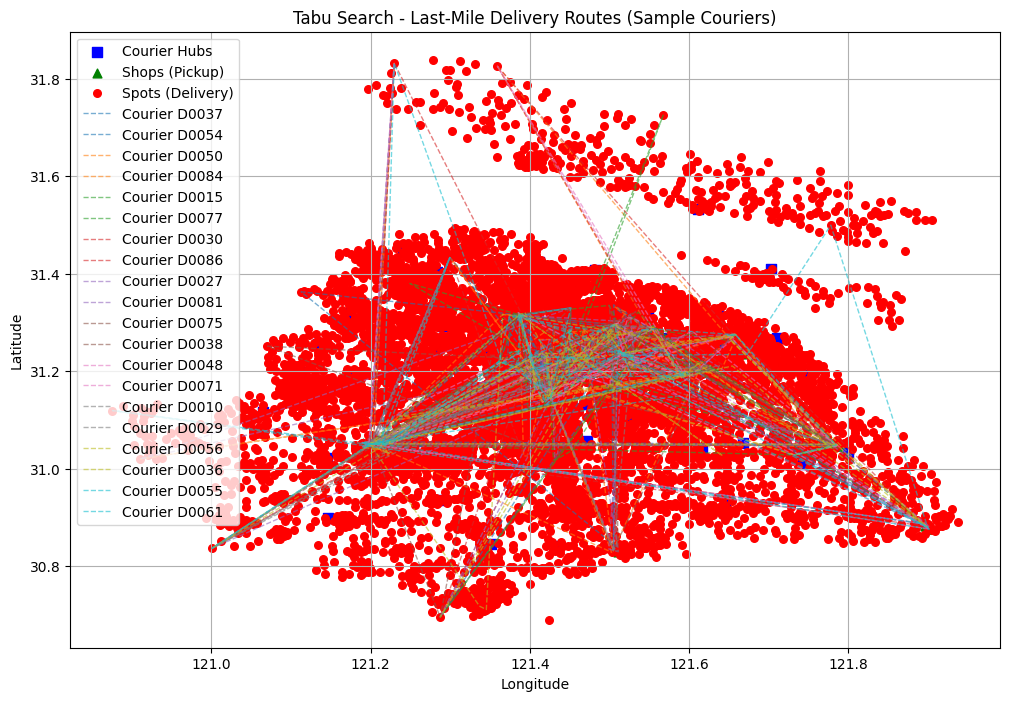

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


sites = pd.read_csv("/content/drive/MyDrive/Dataset/new_1.csv", index_col=0)
spots = pd.read_csv("/content/drive/MyDrive/Dataset/new_2.csv", index_col=0)
shops = pd.read_csv("/content/drive/MyDrive/Dataset/new_3.csv", index_col=0)
orders_ecommerce = pd.read_csv("/content/drive/MyDrive/Dataset/new_4.csv", dtype={"Order_id": str})
orders_o2o = pd.read_csv("/content/drive/MyDrive/Dataset/new_5.csv", dtype={"Order_id": str})

orders_ecommerce.set_index("Order_id", inplace=True)
orders_o2o.set_index("Order_id", inplace=True)
orders_ecommerce.index = orders_ecommerce.index.str.strip()
orders_o2o.index = orders_o2o.index.str.strip()


orders = pd.concat([orders_ecommerce, orders_o2o])
orders = orders[~orders.index.duplicated(keep="first")]
print(f"Total orders after merging: {len(orders)}")

if 'best_solution' not in locals():
    ts_solver = TabuSearchLMDRP(sites, spots, shops, orders, couriers)
    best_solution, best_cost = ts_solver.run()

best_solution = {k: [str(v).strip() for v in lst] for k, lst in best_solution.items()}


site_coords = sites[['Lng', 'Lat']].values
spot_coords = spots[['Lng', 'Lat']].values
shop_coords = shops[['Lng', 'Lat']].values


plt.figure(figsize=(12, 8))
plt.scatter(site_coords[:, 0], site_coords[:, 1], c='blue', label="Courier Hubs", s=50, marker="s")
plt.scatter(shop_coords[:, 0], shop_coords[:, 1], c='green', label="Shops (Pickup)", s=40, marker="^")
plt.scatter(spot_coords[:, 0], spot_coords[:, 1], c='red', label="Spots (Delivery)", s=30, marker="o")

max_couriers_to_plot = 20
selected_couriers = random.sample(list(best_solution.keys()), min(max_couriers_to_plot, len(best_solution)))

colors = plt.cm.get_cmap("tab10", len(selected_couriers))
for idx, courier in enumerate(selected_couriers):
    deliveries = best_solution[courier]
    if not deliveries:
        continue

    route = []
    for order_id in deliveries:
        if order_id not in orders.index:
            print(f"Warning: Order {order_id} not found in dataset. Skipping...")
            continue
        order = orders.loc[order_id]
        if order['Shop_id'] in shops.index and order['Spot_id'] in spots.index:
            shop = shops.loc[order['Shop_id']]
            spot = spots.loc[order['Spot_id']]
            route.append((shop['Lng'], shop['Lat']))
            route.append((spot['Lng'], spot['Lat']))


    unique_route = []
    for point in route:
        if point not in unique_route:
            unique_route.append(point)
    route = np.array(unique_route)

    if len(route) > 1:
        plt.plot(route[:, 0], route[:, 1], linestyle="--", linewidth=1, alpha=0.6, color=colors(idx), label=f"Courier {courier}")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Tabu Search - Last-Mile Delivery Routes (Sample Couriers)")
plt.legend()
plt.grid(True)
plt.show()
